In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

In [2]:
nome_file='Thuesday-20-02-2018_TrafficForML_CICFlowMeter'

with open('pickle/'+nome_file+'/scaled_document.pickle', 'rb') as handle:

    df = pickle.load(handle)

In [3]:
# Seleziona una frazione casuale delle righe in base a una colonna specifica
# Selezioniamo il 50% delle righe

colonna_interessata = 'Label'
frazione_da_selezionare = 0.1  # Ad esempio, seleziona il 50% delle righe


df = df.groupby(colonna_interessata).apply(lambda x: x.sample(frac=frazione_da_selezionare, random_state=42)).reset_index(drop=True)

In [4]:
feature_1 = 'Flow IAT Min'
feature_2 = 'RST Flag Cnt'

df = df[[feature_1, feature_2,'Label']]

In [5]:
df_prova = df.groupby(['Label'])['Label'].count()


df_prova=df_prova.to_frame()
print(df_prova)
df_prova.set_index('Label')
df_prova=df_prova.rename(columns={'n elementi':'Count'})

        Label
Label        
0      731310
1       57619


In [6]:
dos_loic = df[df.Label == 1]
benign = df[df.Label == 0]

print("Benign: ", len(benign), "DoS Attack - Loic HTTP: ", len(dos_loic))

Benign:  731310 DoS Attack - Loic HTTP:  57619


In [7]:
#bilanciamento del dataset
balanced_d = pd.concat([dos_loic, benign.sample(len(dos_loic))])
bal_x = balanced_d.iloc[:,:-1]
bal_y = balanced_d.iloc[:,-1:]
balanced_d.shape

(115238, 3)

In [ ]:
scatter_plot= plt.scatter(balanced_d[feature_1],balanced_d[feature_2],c=balanced_d['Label'])
scatter_plot

plt.xlabel(feature_1)
plt.ylabel(feature_2)

# Aggiungi la legenda
plt.legend(handles=scatter_plot.legend_elements()[0], labels=['Benign', 'DoS Attack Loic HTTP'])

title = ("Scatter " + str(feature_1) + " - " + str(feature_2))
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file):
    os.makedirs('image/'+nome_file)
plt.savefig('image/'+nome_file +'/'+str(feature_name)+'.png')

In [8]:
n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

In [9]:
# Eseguiamo il clustering con Kmeans

km = KMeans(n_clusters=n_clusters)
y_pred = km.fit_predict(bal_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = bal_x[y_pred == i]
    cluster_classes = bal_y[y_pred == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
#plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centroid')

difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)


In [11]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred))
    if y_pred[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred[a] = true_value


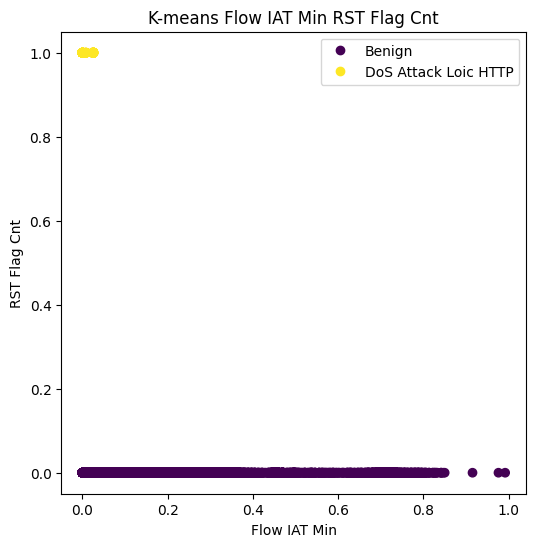

In [12]:
# Plot dei risultati

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
scatter_plot = axs.scatter(bal_x[feature_1], bal_x[feature_2], c=y_pred)
scatter_plot
axs.set_title("K-means " + str(feature_1) + " " + str(feature_2))
plt.xlabel(feature_1)
plt.ylabel(feature_2)

# Aggiungi la legenda
plt.legend(handles=scatter_plot.legend_elements()[0], labels=['Benign', 'DoS Attack Loic HTTP'])

title = ("K-means " + str(feature_1) + " - " + str(feature_2))
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering/'):
    os.makedirs('image/'+nome_file+'/clustering/')
plt.savefig('image/'+nome_file+'/clustering/'+str(feature_name)+'.png')

plt.show()

In [13]:
accuracy_kmeans = str(accuracy_score(y_pred,bal_y))
precision_kmeans = str(precision_score(y_pred,bal_y,average='macro'))
recall_kmeans = str(recall_score(y_pred,bal_y,average='macro'))

# accuratezza kmeans
print("accuratezza " + accuracy_kmeans)
# precision kmeans
print("precision " + precision_kmeans)
# recall kemans
print("recall " + recall_kmeans)


metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_kmeans,precision_kmeans,recall_kmeans]
})

if not os.path.exists('metriche/'+ nome_file + '/clustering/'):
    os.makedirs('metriche/'+ nome_file + '/clustering/')

metriche.to_csv('metriche/'+nome_file+ '/clustering' +'/metriche_kmeans.csv',index=False)

accuratezza 0.6552612853399052
precision 0.6552612853399052
recall 0.6715384114974878


In [14]:
#clustering gerarchico

hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(bal_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = bal_x[y_hc == i]
    cluster_classes = bal_y[y_hc == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class
        

/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [15]:

difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [16]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_hc))
    if y_hc[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_hc[a] = true_value

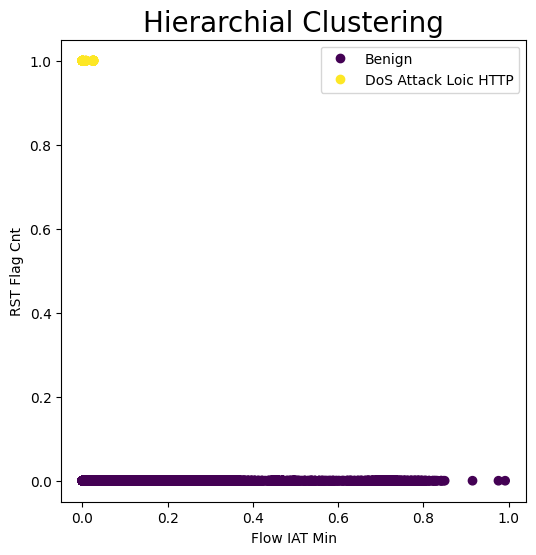

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
scatter_plot = axs.scatter(bal_x.iloc[:, 0], bal_x.iloc[:, 1], c=y_hc)
scatter_plot

plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel(feature_1)
plt.ylabel(feature_2)

# Aggiungi la legenda
plt.legend(handles=scatter_plot.legend_elements()[0], labels=['Benign', 'DoS Attack Loic HTTP'])

title = ("Clust_gerarchico " + str(feature_1) + " - " + str(feature_2))
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering/'):
    os.makedirs('image/'+nome_file+'/clustering/')
plt.savefig('image/'+nome_file+'/clustering/'+str(feature_name)+'.png')

plt.show()

In [18]:
accuracy_gerarchico = str(accuracy_score(y_hc,bal_y))
precision_gerarchico = str(precision_score(y_hc,bal_y,average='macro'))
recall_gerarchico = str(recall_score(y_hc,bal_y,average='macro'))

# accuratezza gerarchico
print("accuratezza " + accuracy_gerarchico)
# precision gerarchico
print("precision " + precision_gerarchico)
# recall gerarchico
print("recall " + recall_gerarchico)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_gerarchico,precision_gerarchico,recall_gerarchico]
})

if not os.path.exists('metriche/'+ nome_file + '/clustering/'):
    os.makedirs('metriche/'+ nome_file + '/clustering/')

metriche.to_csv('metriche/'+ nome_file + '/clustering' + '/metriche_gerarchico.csv',index=False)

accuratezza 0.6552612853399052
precision 0.6552612853399052
recall 0.6715384114974878


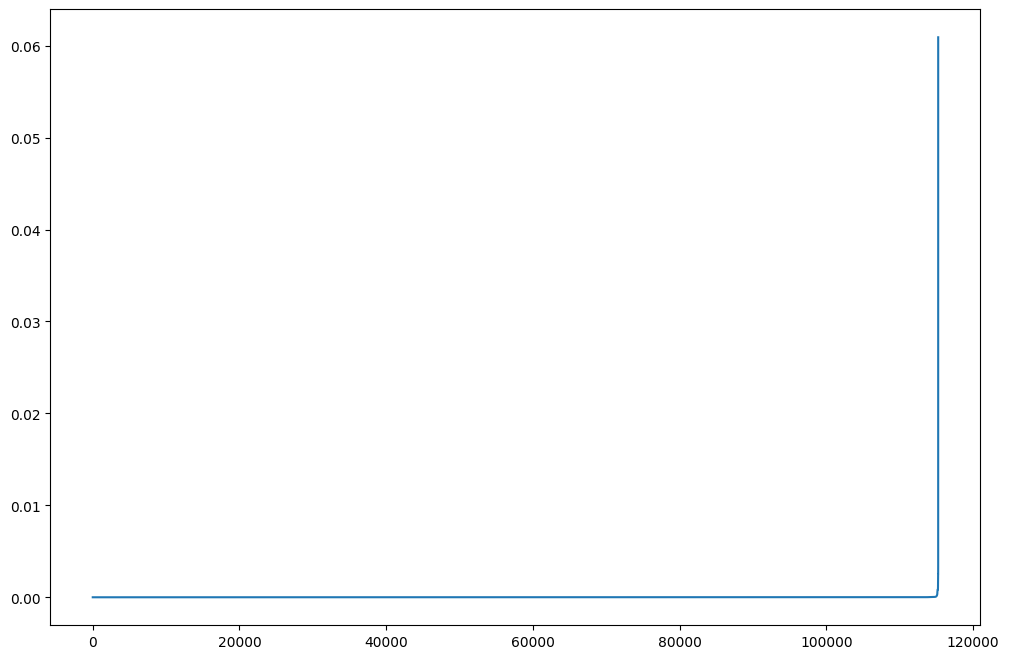

In [19]:
#individuazione dell'eps migliore
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random

values = bal_x.values
neigh = NearestNeighbors(n_neighbors=5, n_jobs=4, algorithm='ball_tree', leaf_size=5)
nbrs = neigh.fit(values)
distances, indices = nbrs.kneighbors(values)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])

In [20]:
# applicazione algoritmo dbscan

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.01, min_samples=6).fit(values)
y_scan = db.labels_
y_scan

array([0, 1, 1, ..., 1, 1, 0])

In [21]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = bal_x[y_scan == i]
    cluster_classes = bal_y[y_scan == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class


In [22]:

difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [23]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_scan))
    if y_scan[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_scan[a] = true_value

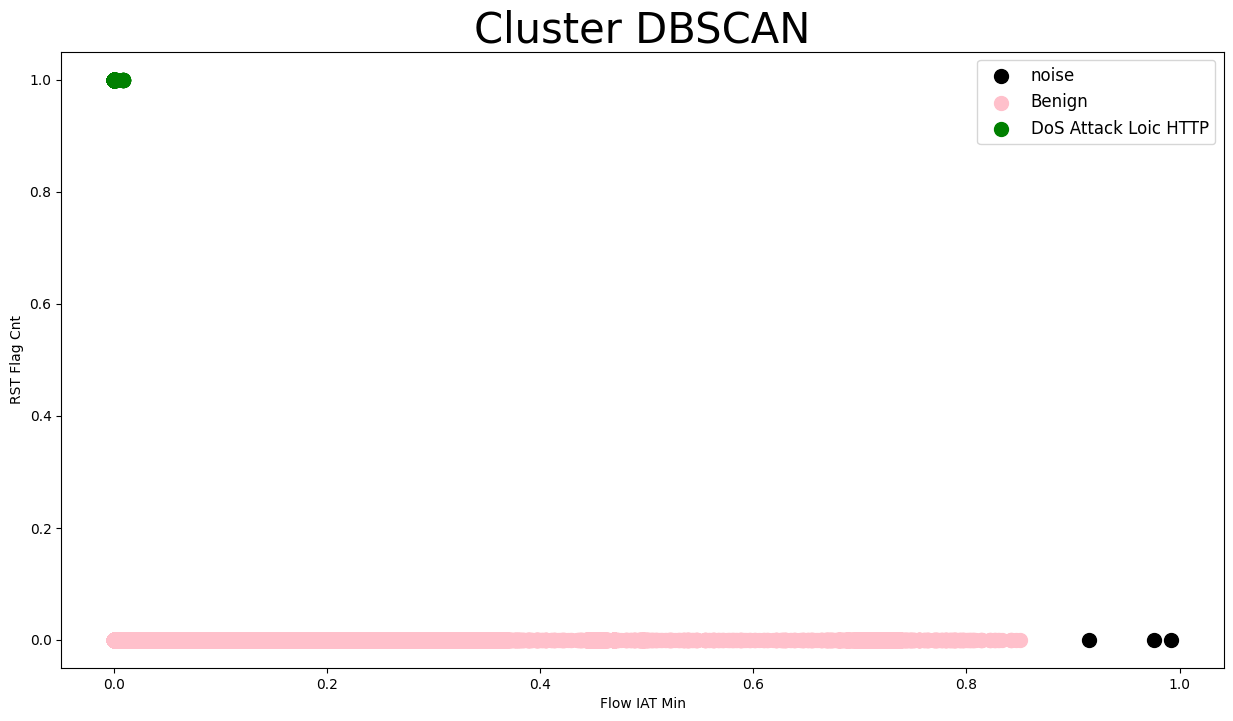

In [24]:
plt.figure(figsize=(15,8))
plt.title('Cluster DBSCAN', fontsize = 30)

plt.scatter(values[y_scan == -1, 0], values[y_scan == -1, 1], s = 100, c = 'black', label = "noise")
plt.scatter(values[y_scan == 0, 0], values[y_scan == 0, 1], s = 100, c = 'pink', label = "Benign")
plt.scatter(values[y_scan == 1, 0], values[y_scan == 1, 1], s = 100, c = 'green', label = 'DoS Attack Loic HTTP') 

plt.xlabel(feature_1)
plt.ylabel(feature_2)

# Add legend
plt.legend(fontsize='large')

title = ("DB_Scan " + str(feature_1) + " - " + str(feature_2))
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering/'):
    os.makedirs('image/'+nome_file+'/clustering/')
plt.savefig('image/'+nome_file+'/clustering/'+str(feature_name)+'.png')


plt.show()

In [25]:
accuracy_dbscan = str(accuracy_score(y_scan,bal_y))
precision_dbscan = str(precision_score(y_scan,bal_y,average='macro'))
recall_dbscan = str(recall_score(y_scan,bal_y,average='macro'))

# accuratezza dbscan
print("accuratezza " + accuracy_dbscan)
# precision dbscan
print("precision " + precision_dbscan)
# recall dbscan
print("recall " + recall_dbscan)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_dbscan,precision_dbscan,recall_dbscan]
})

if not os.path.exists('metriche/'+ nome_file + '/clustering/'):
    os.makedirs('metriche/'+ nome_file + '/clustering/')

metriche.to_csv('metriche/'+nome_file+ '/clustering' +'/metriche_dbscan.csv',index=False)

accuratezza 0.655235252260539
precision 0.32761762613026957
recall 0.33623902835301767


/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Eseguiamo il clustering

n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

y_som = SOM(m=1, n=2, dim=2)

y_som.fit(bal_x.values)

predictions = y_som.predict(bal_x.values)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = bal_x[predictions == i]
    cluster_classes = bal_y[predictions == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [27]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe

for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)
        

In [28]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(predictions))
    if predictions[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        predictions[a] = true_value

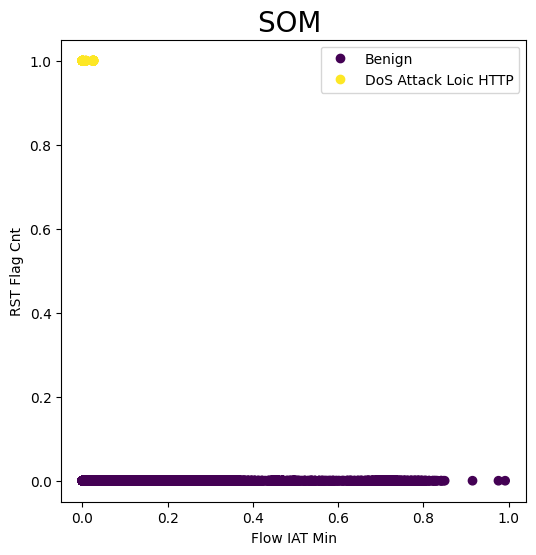

In [29]:
# Plot dei risultati

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
scatter_plot = axs.scatter(bal_x[feature_1], bal_x[feature_2], c=predictions)
scatter_plot

plt.title('SOM ', fontsize = 20)
plt.xlabel(feature_1)
plt.ylabel(feature_2)

# Aggiungi la legenda
plt.legend(handles=scatter_plot.legend_elements()[0], labels=['Benign', 'DoS Attack Loic HTTP'])

title = ("SOM " + str(feature_1) + " - " + str(feature_2))
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering/'):
    os.makedirs('image/'+nome_file+'/clustering/')
plt.savefig('image/'+nome_file+'/clustering/'+str(feature_name)+'.png')

plt.show()

In [30]:
accuracy_som = str(accuracy_score(predictions,bal_y))
precision_som = str(precision_score(predictions,bal_y,average='macro'))
recall_som = str(recall_score(predictions,bal_y,average='macro'))

# accuratezza gerarchico
print("accuratezza " + accuracy_som)
# precision gerarchico
print("precision " + precision_som)
# recall gerarchico
print("recall " + recall_som)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_som,precision_som,recall_som]
})

if not os.path.exists('metriche/'+nome_file+ '/clustering/'):
    os.makedirs('metriche/'+nome_file+ '/clustering/')

metriche.to_csv('metriche/'+nome_file+ '/clustering' + '/metriche_som.csv',index=False)

accuratezza 0.6552612853399052
precision 0.6552612853399052
recall 0.6715384114974878


In [31]:
import gc

gc.collect()

7261